In [240]:
import numpy as np
import pandas as pd
from datetime import timedelta  
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

from scipy.stats import chi2_contingency, chi2 
import pingouin as pg


Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

Описание данных
city – город
phone – основное устройство, которое использует водитель
signup_date – дата регистрации аккаунта (YYYYMMDD)
last_trip_date – дата последней поездки (YYYYMMDD)
avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
avg_rating_by_driver – средняя оценка поездок водителем
avg_rating_of_driver – средняя оценка поездок водителя
surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
avg_surge – средний множитель всплеска за все поездки этого водителя
trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
weekday_pct – процент поездок пользователя, совершен

ных в будние дни
План
Сначала сделаем небольшой препроцессинг:
Посмотрим на данные
Далее сформулируем гипотезы, исходя из общей задачи:
Сформулируем предположения, которые будем тестировать
Создадим лейбл churn/not_churn
Построим графики
Поинт: только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
Тестируем гипотезы:
Выбираем гипотезу
Выбирае
м подходящий тест
Тестируем
Подводим итоги:
Сформулировать выводы и суммаризировать всё что было
Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)

In [242]:
data = pd.read_csv('churn.csv', parse_dates=['signup_date', 'last_trip_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [11]:
data.shape

(50000, 12)

In [15]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [13]:
data.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [23]:
last_day = data['last_trip_date'].max()
data['missed_days'] = abs(data['last_trip_date'] - last_day)
data[['missed_days', 'last_trip_date']]

,missed_days,last_trip_date
0,14 days,2014-06-17
1,57 days,2014-05-05
2,175 days,2014-01-07
3,2 days,2014-06-29
4,108 days,2014-03-15
...,...,...
49995,26 days,2014-06-05
49996,157 days,2014-01-25
49997,40 days,2014-05-22
49998,167 days,2014-01-15


In [35]:
data['churn'] = data['missed_days'].apply(lambda x: 'churn' if x>=timedelta(days=30) else 'not_churn')
data[['churn', 'missed_days']]

,churn,missed_days
0,not_churn,14 days
1,churn,57 days
2,churn,175 days
3,not_churn,2 days
4,churn,108 days
...,...,...
49995,not_churn,26 days
49996,churn,157 days
49997,churn,40 days
49998,churn,167 days


churn & phone
Предположим, что проблема может быть среди юзеров на конкретной платформе:

<Axes: xlabel='churn', ylabel='count'>

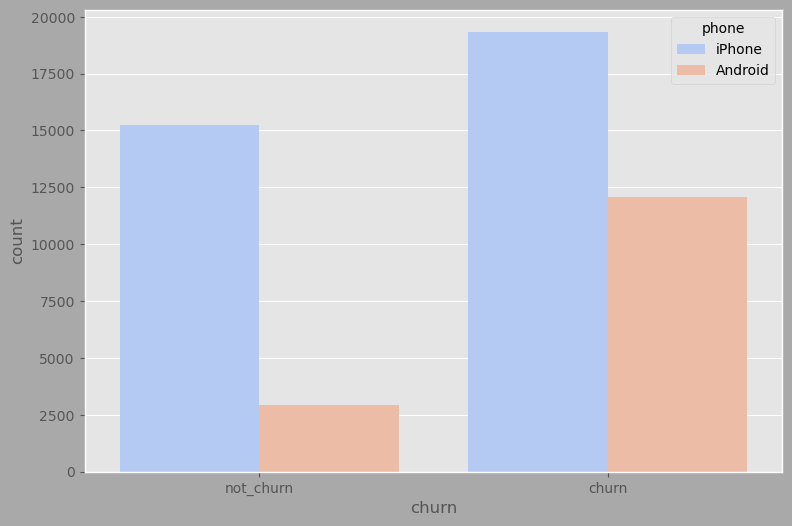

In [53]:
plt.figure(figsize=(9, 6), facecolor='#A9A9A9')
sns.countplot(data=data, x='churn', palette='coolwarm', hue='phone')

In [69]:
data.groupby('phone').churn.value_counts(normalize=True).mul(100)

phone    churn    
Android  churn        80.415391
         not_churn    19.584609
iPhone   churn        55.936614
         not_churn    44.063386
Name: proportion, dtype: float64

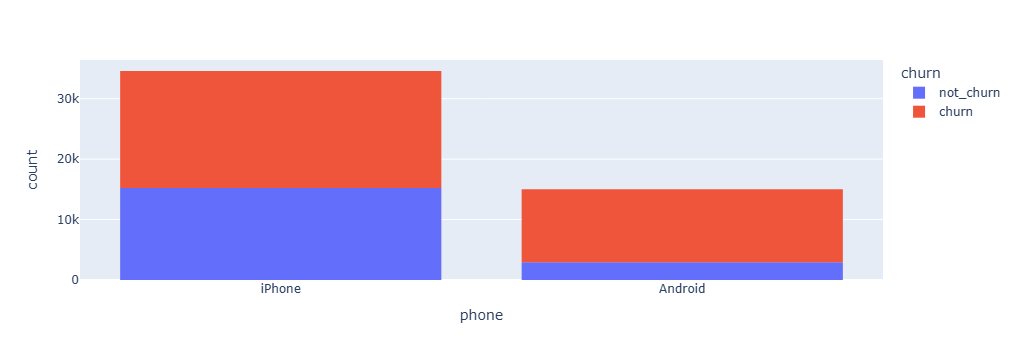

In [73]:
fig = px.histogram(data[['churn', 'phone']].dropna(), x='phone', 
                   color='churn')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

Но: взаимосвязи между переменными нет
Н1: взаимосвязь есть

In [79]:
expected, observed, stats = pg.chi2_independence(data, x='churn', y='phone')
expected

phone,Android,iPhone
churn,,
churn,9516.39642,21907.60358
not_churn,5505.60358,12674.39642


In [81]:
observed

phone,Android,iPhone
churn,,
churn,12079.5,19344.5
not_churn,2942.5,15237.5


In [85]:
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,2701.775,1.0,0.0,0.232,1.0
1,cressie-read,0.667,2750.046,1.0,0.0,0.235,1.0
2,log-likelihood,0.000,2873.620,1.0,0.0,0.240,1.0
3,freeman-tukey,-0.500,2993.899,1.0,0.0,0.245,1.0
4,mod-log-likelihood,-1.000,3142.505,1.0,0.0,0.251,1.0
5,neyman,-2.000,3547.226,1.0,0.0,0.266,1.0


Отклоняем нулевую гипотезу. Взаимосавязь на лицо

Вопросы для проверки:1. 
Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)2. 
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days3. )
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_dayданных
city – город
phone – основное устройство, которое использует водитель
signup_date – дата регистрации аккаунта (YYYYMMDD)
last_trip_date – дата последней поездки (YYYYMMDD)
avg_dist – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
avg_rating_by_driver – средняя оценка поездок водителем
vg_rating_of_driver – средняя оценка поездок водителя
surge_pct – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
avg_surge – средний множитель всплеска за все поездки этого водителя
trips_in_first_30_days – количество поездок, которые совершил водитель в первые 30 дней после регистрации
luxury_car_user – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
weekday_pct – процент поездок пользователя, совершенных в будние дни

In [87]:
data.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

1. churn & phone
Предположим, что проблема может быть среди юзеров в разных городах:

<Axes: xlabel='city', ylabel='count'>

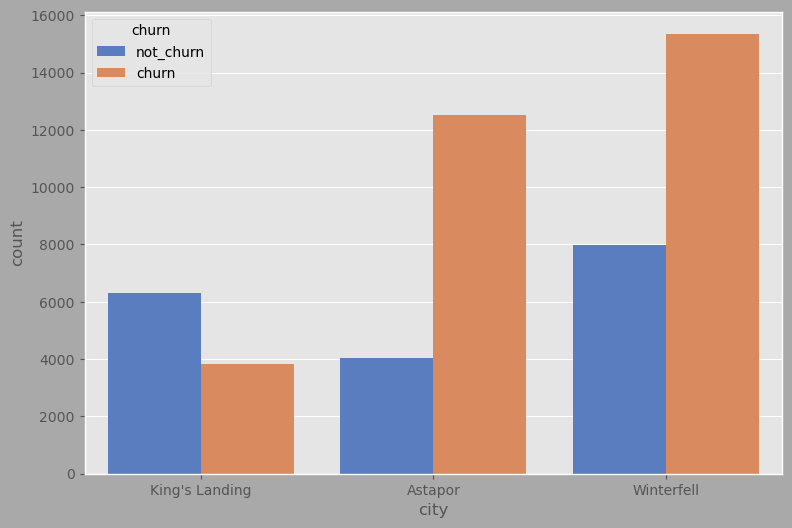

In [97]:
plt.figure(figsize=(9, 6), facecolor='#A9A9A9')
sns.countplot(data=data, x='city', palette='muted', hue='churn')

In [99]:
data.groupby('city').churn.value_counts(normalize=True).mul(100)

city            churn    
Astapor         churn        75.674368
                not_churn    24.325632
King's Landing  not_churn    62.260612
                churn        37.739388
Winterfell      churn        65.799623
                not_churn    34.200377
Name: proportion, dtype: float64

In [109]:
expected, observed, stats = pg.chi2_independence(data, x='churn', y='city')
expected.round()

city,Astapor,King's Landing,Winterfell
churn,,,
churn,10479.0,6420.0,14790.0
not_churn,6055.0,3710.0,8546.0


In [115]:
observed

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12512,3823,15355
not_churn,4022,6307,7981


In [117]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,4005.056400,2.0,0.0,0.283021,1.0
1,cressie-read,0.666667,3964.974525,2.0,0.0,0.281602,1.0
2,log-likelihood,0.000000,3936.129797,2.0,0.0,0.280575,1.0
3,freeman-tukey,-0.500000,3958.146081,2.0,0.0,0.281359,1.0
4,mod-log-likelihood,-1.000000,4017.462704,2.0,0.0,0.283459,1.0
5,neyman,-2.000000,4252.707864,2.0,0.0,0.291640,1.0


Отклоняем нулевую гипотезу, взаимосвязь между оттоком водителей в последние 30 дней с городом их местоположения есть.

2. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [119]:
data[['city', 'trips_in_first_30_days']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   city                    50000 non-null  object
 1   trips_in_first_30_days  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [138]:
data['trips_in_first_30_days'].describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

Посмотрим на распределения активности в первые 30 дней в общем наборе без разделения на города.

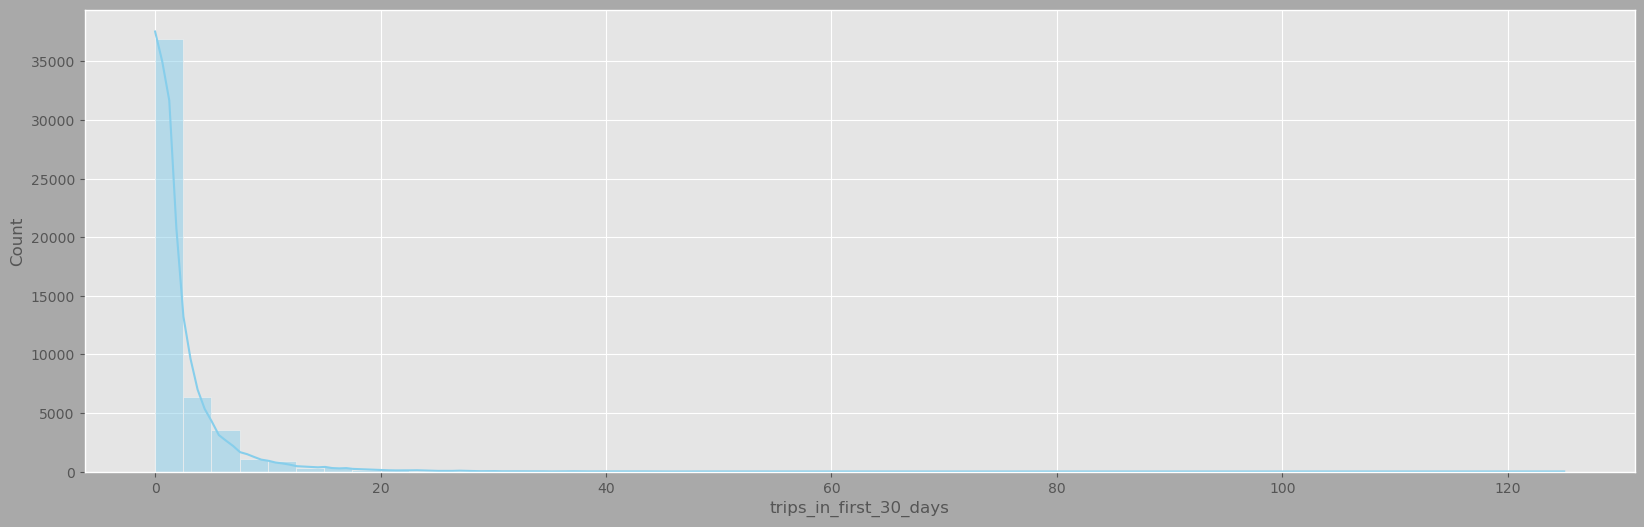

In [210]:
plt.figure(figsize=(20, 6), facecolor='#A9A9A9')
sns.histplot(data.trips_in_first_30_days,bins=50,color='skyblue', kde=True)
plt.show()

In [182]:
Astapor = data.query('city == "Astapor"')
KingsLanding = data.query('city == "King\'s Landing"')
Winterfell = data.query('city == "Winterfell"')

Text(0.5, 1.0, 'Winterfell')

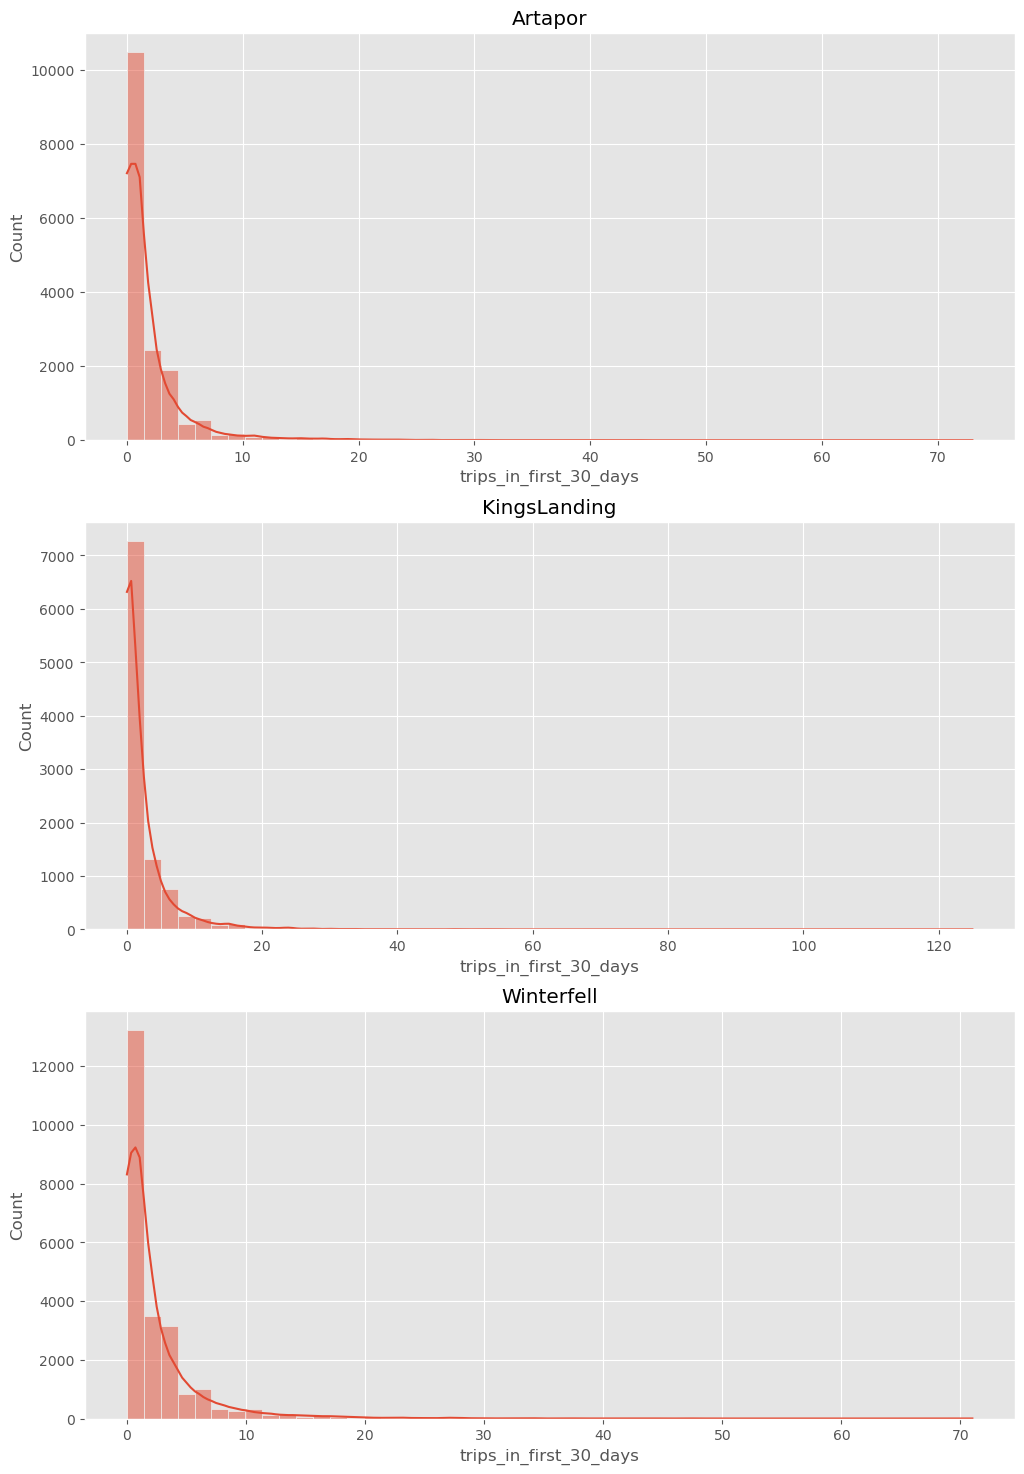

In [190]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.histplot(Astapor.trips_in_first_30_days, kde=True,bins=50, ax=axes[0])
axes[0].set_title('Artapor')

sns.histplot(KingsLanding.trips_in_first_30_days, kde=True, bins=50, ax=axes[1])
axes[1].set_title('KingsLanding')

sns.histplot(Winterfell.trips_in_first_30_days, kde=True, bins=50, ax=axes[2])
axes[2].set_title('Winterfell')

In [206]:
print(pg.normality(Astapor.trips_in_first_30_days.sample(5000)))
print(pg.normality(KingsLanding.trips_in_first_30_days.sample(5000)))
print(pg.normality(Winterfell.trips_in_first_30_days.sample(5000)))

                               W          pval  normal
trips_in_first_30_days  0.524382  4.513809e-79   False
                               W          pval  normal
trips_in_first_30_days  0.586191  4.120184e-76   False
                               W          pval  normal
trips_in_first_30_days  0.611417  8.579365e-75   False


In [ ]:
Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса.

In [212]:
from scipy.stats import kruskal

In [214]:
kruskal(Astapor.trips_in_first_30_days, KingsLanding.trips_in_first_30_days, Winterfell.trips_in_first_30_days)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

In [216]:
pg.kruskal(data=data, dv='trips_in_first_30_days', between='city')

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


p-value = 8.724568e-49, а значит можно отклонить нулевую гипотезу и заключить, что есть статистически значимая разница между группами.

3. Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [218]:
print(pg.normality(data[data['churn']=='churn'].trips_in_first_30_days.sample(5000)))
print(pg.normality(data[data['churn']=='not_churn'].trips_in_first_30_days.sample(5000)))

                               W          pval  normal
trips_in_first_30_days  0.556055  1.340407e-77   False
                              W          pval  normal
trips_in_first_30_days  0.61021  7.391539e-75   False


In [ ]:
Используем критерий Мана-Уитни для проверки гипотезы связи оттока с активностью в перве 30 дней.

In [220]:
pg.mwu(data[data['churn']=='churn'].trips_in_first_30_days, data[data['churn']=='not_churn'].trips_in_first_30_days)

,U-val,alternative,p-val,RBC,CLES
MWU,229736009.5,two-sided,0.0,-0.20814,0.39593


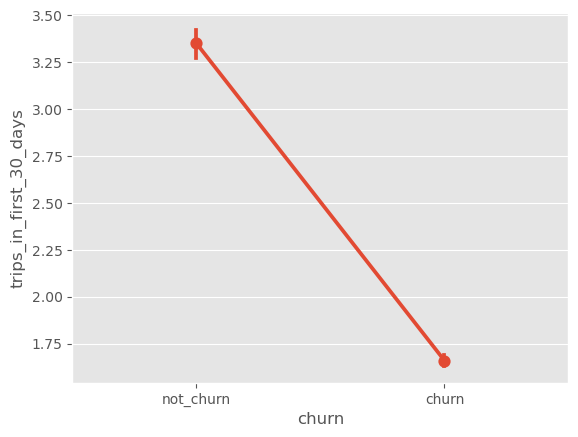

In [226]:
sns.pointplot(data=data, y='trips_in_first_30_days', x='churn')
plt.show()

Исходя из полученного значения вероятности теста выше можем заключить, что статистически значимая разница между двумя группами данных присутствует. Менее активные водители в первые 30 дней с момента регистрации ушли из приложения.

In [234]:
data.signup_date.describe()

count                         50000
mean     2014-01-16 13:04:20.352000
min             2014-01-01 00:00:00
25%             2014-01-09 00:00:00
50%             2014-01-17 00:00:00
75%             2014-01-24 00:00:00
max             2014-01-31 00:00:00
Name: signup_date, dtype: object